In [1]:
!pip install transformers captum captum scikit-learn --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 24.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 119.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 1.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 95.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 94.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 43.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 1.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 14.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 8.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2

In [1]:
import torch
from transformers import AutoModelForSequenceClassification, AutoTokenizer
from captum.attr import visualization as viz

# Load model and tokenizer
model_name = "distilbert-base-uncased-finetuned-sst-2-english"
model = AutoModelForSequenceClassification.from_pretrained(model_name)
tokenizer = AutoTokenizer.from_pretrained(model_name)

# Label names
label_names = ["Negative", "Positive"]


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/629 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

Analyzing text: 'I was skeptical about the new phone, expecting poor performance, but its fast processor and stunning display completely changed my mind.'
Target label: Positive


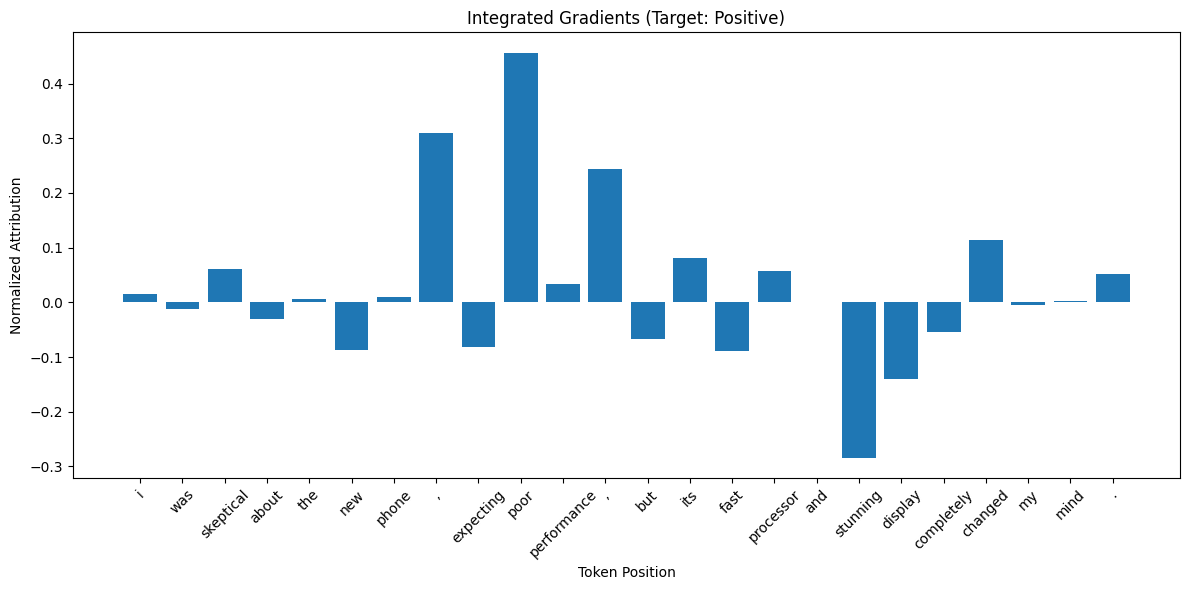

True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
Positive,Positive (Pred) (0.98),Positive,0.60,"i was skeptical about the new phone , expecting poor performance , but its fast processor and stunning display completely changed my mind ."



[Infidelity on Embedding Inputs via Integrated Gradients]
  Infidelity: 0.000362
  Noise Level: 0.1
  Perturbation Samples: 20


In [ ]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
from captum.attr import IntegratedGradients
from captum.metrics import infidelity
from captum.attr import visualization as viz

class IntegratedGradientsAnalyzer:
    def __init__(self, model, tokenizer, label_names):
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.model = model.to(self.device).eval()
        self.tokenizer = tokenizer
        self.label_names = label_names

    def preprocess(self, text):
        inputs = self.tokenizer(
            text, return_tensors="pt", padding=True, truncation=True, max_length=512
        )
        return {k: v.to(self.device) for k, v in inputs.items()}

    def forward_func(self, input_ids, attention_mask):
        input_ids = input_ids.long()
        outputs = self.model(input_ids=input_ids, attention_mask=attention_mask)
        return F.softmax(outputs.logits, dim=-1)

    def forward_embeds(self, embeds, attention_mask):
        outputs = self.model.distilbert(inputs_embeds=embeds, attention_mask=attention_mask)
        hidden_states = outputs.last_hidden_state
        cls_output = hidden_states[:, 0]
        logits = self.model.classifier(cls_output)
        return torch.nn.functional.softmax(logits, dim=-1)

    def get_integrated_gradients_attributions(self, text, target_label):
        inputs = self.preprocess(text)
        input_ids = inputs["input_ids"]
        attention_mask = inputs["attention_mask"]

        embedding_layer = self.model.distilbert.embeddings
        embeds = embedding_layer(input_ids)

        baseline_ids = torch.full_like(input_ids, self.tokenizer.pad_token_id)
        baseline_embeds = embedding_layer(baseline_ids)

        ig = IntegratedGradients(self.forward_embeds)
        attributions, delta = ig.attribute(
            inputs=embeds,
            baselines=baseline_embeds,
            additional_forward_args=(attention_mask,),
            target=target_label,
            return_convergence_delta=True
        )

        return {
            "attributions": attributions,
            "delta": delta,
            "input_ids": input_ids,
            "attention_mask": attention_mask,
            "embeds": embeds,
            "baseline_embeds": baseline_embeds
        }

    def visualize_integrated_gradients(self, result, target_label):
        input_ids = result["input_ids"]
        attention_mask = result["attention_mask"]
        attributions = result["attributions"]
        delta = result["delta"]

        tokens = self.tokenizer.convert_ids_to_tokens(input_ids[0])
        probs = self.forward_func(input_ids, attention_mask)
        pred_label = torch.argmax(probs, dim=1).item()
        pred_score = torch.max(probs).item()

        attr_sum = attributions.sum(dim=-1).squeeze(0)
        attr_norm = attr_sum / torch.norm(attr_sum)

        plt.figure(figsize=(12, 6))
        filtered_tokens = []
        filtered_attrs = []
        for token, attr in zip(tokens, attr_norm):
            if token not in ["[CLS]", "[SEP]", "[PAD]"]:
                filtered_tokens.append(token)
                filtered_attrs.append(attr.item())

        plt.bar(range(len(filtered_tokens)), filtered_attrs)
        plt.xticks(range(len(filtered_tokens)), filtered_tokens, rotation=45)
        plt.title(f"Integrated Gradients (Target: {self.label_names[target_label]})")
        plt.ylabel("Normalized Attribution")
        plt.xlabel("Token Position")
        plt.tight_layout()
        plt.show()

        vis_record = viz.VisualizationDataRecord(
            filtered_attrs,
            pred_score,
            f"{self.label_names[pred_label]} (Pred)",
            self.label_names[target_label],
            self.label_names[target_label],
            sum(filtered_attrs),
            filtered_tokens,
            delta.item()
        )

        viz.visualize_text([vis_record])

    def compute_infidelity_on_embeddings(self, result, target_label, noise_level=0.1, n_perturb_samples=20):
        embeds = result["embeds"]
        attention_mask = result["attention_mask"]
        attributions = result["attributions"]

        def perturb_fn(input_embeds):
            noise = torch.randn_like(input_embeds) * noise_level
            return noise, input_embeds + noise

        infid = infidelity(
            forward_func=self.forward_embeds,
            perturb_func=perturb_fn,
            inputs=embeds,
            attributions=attributions,
            additional_forward_args=(attention_mask,),
            target=target_label,
            n_perturb_samples=n_perturb_samples
        )

        print(f"\n[Infidelity on Embedding Inputs via Integrated Gradients]")
        print(f"  Infidelity: {infid.item():.6f}")
        print(f"  Noise Level: {noise_level}")
        print(f"  Perturbation Samples: {n_perturb_samples}")

        return infid.item()

    def run_analysis(self, text, target_label):
        print(f"Analyzing text: '{text}'")
        print(f"Target label: {self.label_names[target_label]}")

        result = self.get_integrated_gradients_attributions(text, target_label)
        self.visualize_integrated_gradients(result, target_label)
        infid_score = self.compute_infidelity_on_embeddings(result, target_label)

        return result, infid_score
analyzer = IntegratedGradientsAnalyzer(model, tokenizer, label_names)
text = "I was skeptical about the new phone, expecting poor performance, but its fast processor and stunning display completely changed my mind."
target_label = 1  # Positive
result, infidelity_score = analyzer.run_analysis(text, target_label)


Analyzing text: 'I was skeptical about the new phone, expecting poor performance, but its fast processor and stunning display completely changed my mind.'
Target label: Positive


True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
Positive,Positive (embeddings) (0.98),Positive,1.65,"i was skeptical about the new phone , expecting poor performance , but its fast processor and stunning display completely changed my mind ."
Positive,Positive (layer_0) (0.98),Positive,1.22,"i was skeptical about the new phone , expecting poor performance , but its fast processor and stunning display completely changed my mind ."
Positive,Positive (layer_2) (0.98),Positive,0.80,"i was skeptical about the new phone , expecting poor performance , but its fast processor and stunning display completely changed my mind ."
Positive,Positive (layer_4) (0.98),Positive,1.39,"i was skeptical about the new phone , expecting poor performance , but its fast processor and stunning display completely changed my mind ."


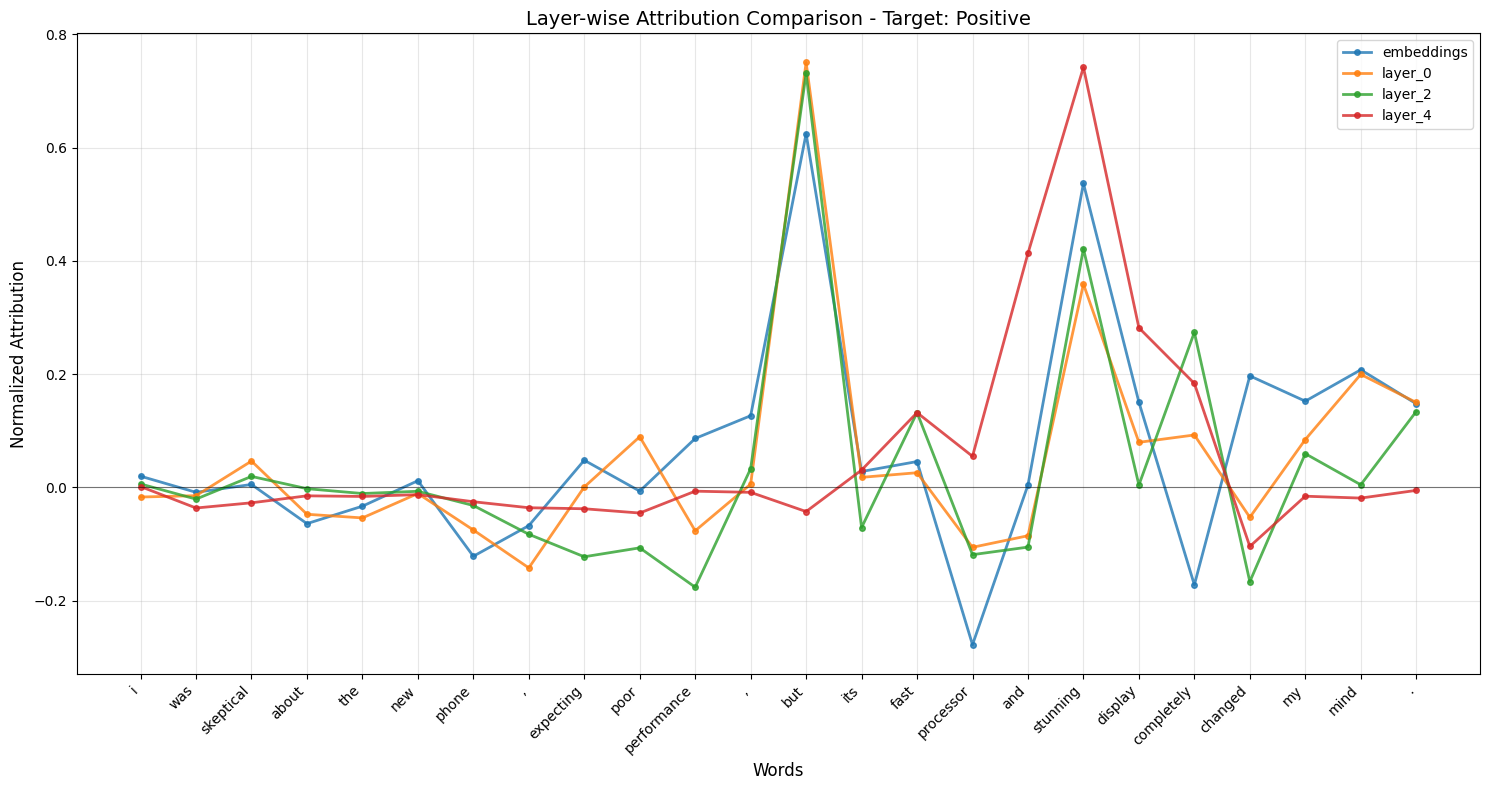


[Infidelity on Embedding Inputs via Layer 0 Attribution]
  Infidelity: 0.000841
  Convergence Delta: 0.001443
  Noise Level: 0.1
  Perturbation Samples: 20


In [ ]:
from captum.attr import LayerIntegratedGradients
from captum.metrics import infidelity
from captum.attr import visualization as viz
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np

class LIGAttributionAnalyzer:
    def __init__(self, model, tokenizer, label_names):
        self.model = model
        self.tokenizer = tokenizer
        self.label_names = label_names
        self.layer_dict = {
            "embeddings": model.distilbert.embeddings,
            "layer_0": model.distilbert.transformer.layer[0],
            "layer_2": model.distilbert.transformer.layer[2],
            "layer_4": model.distilbert.transformer.layer[4],
        }

    def preprocess(self, text):
        """Preprocess text for model input"""
        return self.tokenizer(
            text,
            return_tensors="pt",
            padding=True,
            truncation=True,
            max_length=512
        )

    def forward_func(self, input_ids, attention_mask):
        """Standard forward function using input_ids"""
        outputs = self.model(input_ids=input_ids, attention_mask=attention_mask)
        return F.softmax(outputs.logits, dim=-1)

    def forward_embeds(self, inputs_embeds, attention_mask):
        """Forward function that accepts embeddings directly"""
        outputs = self.model(inputs_embeds=inputs_embeds, attention_mask=attention_mask)
        return F.softmax(outputs.logits, dim=-1)

    def get_layerwise_attributions(self, text, target_label):
        """Get LIG attributions for all specified layers"""
        inputs = self.preprocess(text)
        input_ids = inputs["input_ids"]
        attention_mask = inputs["attention_mask"]
        ref_input_ids = torch.full_like(input_ids, self.tokenizer.pad_token_id)

        results = {}

        for layer_name, layer in self.layer_dict.items():
            lig = LayerIntegratedGradients(self.forward_func, layer)
            attributions, delta = lig.attribute(
                inputs=input_ids,
                baselines=ref_input_ids,
                additional_forward_args=(attention_mask,),
                target=target_label,
                return_convergence_delta=True
            )
            results[layer_name] = {
                "attributions": attributions,
                "delta": delta,
                "convergence_delta": delta.item()
            }

        return results, input_ids, attention_mask

    def visualize_multiple_layers(self, results, input_ids, attention_mask, target_label):
        """Visualize attributions for all layers"""
        tokens = self.tokenizer.convert_ids_to_tokens(input_ids[0])
        probs = self.forward_func(input_ids, attention_mask)
        pred_label = torch.argmax(probs, dim=1).item()
        pred_score = torch.max(probs).item()

        vis_records = []

        for layer_name, result in results.items():
            # Sum over embedding dimension and squeeze batch dimension
            attributions = result["attributions"].sum(dim=-1).squeeze(0)

            # Normalize attributions
            attr_norm = attributions / torch.norm(attributions)

            # Filter out special tokens
            filtered_tokens = []
            filtered_attrs = []
            for token, attr in zip(tokens, attr_norm):
                if token not in ["[CLS]", "[SEP]", "[PAD]"]:
                    filtered_tokens.append(token)
                    filtered_attrs.append(attr.item())

            vis_records.append(
                viz.VisualizationDataRecord(
                    filtered_attrs,
                    pred_score,
                    f"{self.label_names[pred_label]} ({layer_name})",
                    self.label_names[target_label],
                    self.label_names[target_label],
                    sum(filtered_attrs),
                    filtered_tokens,
                    result["convergence_delta"]
                )
            )

        viz.visualize_text(vis_records)

    def plot_layerwise_attributions(self, results, input_ids, target_label):
        """Plot line graph showing normalized attributions across layers"""
        tokens = self.tokenizer.convert_ids_to_tokens(input_ids[0])

        # Filter out special tokens first
        filtered_tokens = []
        filtered_indices = []
        for i, token in enumerate(tokens):
            if token not in ["[CLS]", "[SEP]", "[PAD]"]:
                filtered_tokens.append(token)
                filtered_indices.append(i)

        # Define colors for each layer (visually distinct)
        colors = {
            "embeddings": "#1f77b4",  # Blue
            "layer_0": "#ff7f0e",     # Orange
            "layer_2": "#2ca02c",     # Green
            "layer_4": "#d62728"      # Red
        }

        plt.figure(figsize=(15, 8))

        for layer_name, result in results.items():
            # Sum over embedding dimension and squeeze batch dimension
            attributions = result["attributions"].sum(dim=-1).squeeze(0)

            # Normalize attributions
            attr_norm = attributions / torch.norm(attributions)

            # Filter attributions for non-special tokens
            filtered_attrs = [attr_norm[i].item() for i in filtered_indices]

            # Plot line for this layer
            plt.plot(range(len(filtered_tokens)), filtered_attrs,
                    color=colors[layer_name], marker='o', linewidth=2,
                    markersize=4, label=layer_name, alpha=0.8)

        plt.xlabel('Words', fontsize=12)
        plt.ylabel('Normalized Attribution', fontsize=12)
        plt.title(f'Layer-wise Attribution Comparison - Target: {self.label_names[target_label]}', fontsize=14)
        plt.xticks(range(len(filtered_tokens)), filtered_tokens, rotation=45, ha='right')
        plt.legend(fontsize=10)
        plt.grid(True, alpha=0.3)
        plt.axhline(y=0, color='black', linestyle='-', alpha=0.5, linewidth=0.8)
        plt.tight_layout()
        plt.show()

    def compute_infidelity_on_embeddings(self, text, target_label, noise_level=0.1, n_perturb_samples=20):
        """
        Compute infidelity metric on embeddings layer

        Args:
            text: Input text
            target_label: Target class label
            noise_level: Standard deviation of noise for perturbations
            n_perturb_samples: Number of perturbation samples for infidelity computation
        """
        inputs = self.preprocess(text)
        input_ids = inputs["input_ids"].long()
        attention_mask = inputs["attention_mask"]
        ref_input_ids = torch.full_like(input_ids, self.tokenizer.pad_token_id).long()

        # Convert input_ids to embeddings
        embedding_layer = self.model.distilbert.embeddings
        embeds = embedding_layer(input_ids)
        baseline_embeds = embedding_layer(ref_input_ids)

        # Use first transformer layer for attribution on embeddings (following original approach)
        lig = LayerIntegratedGradients(self.forward_embeds, self.model.distilbert.transformer.layer[0])

        attributions, delta = lig.attribute(
            inputs=embeds,
            baselines=baseline_embeds,
            additional_forward_args=(attention_mask,),
            target=target_label,
            return_convergence_delta=True
        )

        # Define perturbation function
        def perturb_fn(x):
            """Add Gaussian noise to embeddings"""
            noise = torch.randn_like(x) * noise_level
            return noise, x + noise

        # Compute infidelity
        infid = infidelity(
            forward_func=self.forward_embeds,
            perturb_func=perturb_fn,
            inputs=embeds,
            attributions=attributions,
            additional_forward_args=(attention_mask,),
            target=target_label,
            n_perturb_samples=n_perturb_samples
        )

        print(f"\n[Infidelity on Embedding Inputs via Layer 0 Attribution]")
        print(f"  Infidelity: {infid.item():.6f}")
        print(f"  Convergence Delta: {delta.item():.6f}")
        print(f"  Noise Level: {noise_level}")
        print(f"  Perturbation Samples: {n_perturb_samples}")

        return infid.item(), delta.item()

    def run_analysis(self, text, target_label):
        """Run complete attribution analysis"""
        print(f"Analyzing text: '{text}'")
        print(f"Target label: {self.label_names[target_label]}")

        # Get layerwise attributions
        results, input_ids, attention_mask = self.get_layerwise_attributions(text, target_label)

        # Visualize attributions
        self.visualize_multiple_layers(results, input_ids, attention_mask, target_label)

        # Plot layerwise attribution comparison
        self.plot_layerwise_attributions(results, input_ids, target_label)

        # Compute infidelity on embeddings
        infid_score, conv_delta = self.compute_infidelity_on_embeddings(text, target_label)

        return results, infid_score, conv_delta

# Usage example:
analyzer = LIGAttributionAnalyzer(model, tokenizer, label_names)
text = "I was skeptical about the new phone, expecting poor performance, but its fast processor and stunning display completely changed my mind."
target_label = 1
results, infidelity_score, convergence_delta = analyzer.run_analysis(text, target_label)

Analyzing text: 'I was skeptical about the new phone, expecting poor performance, but its fast processor and stunning display completely changed my mind.'
Target label: Positive


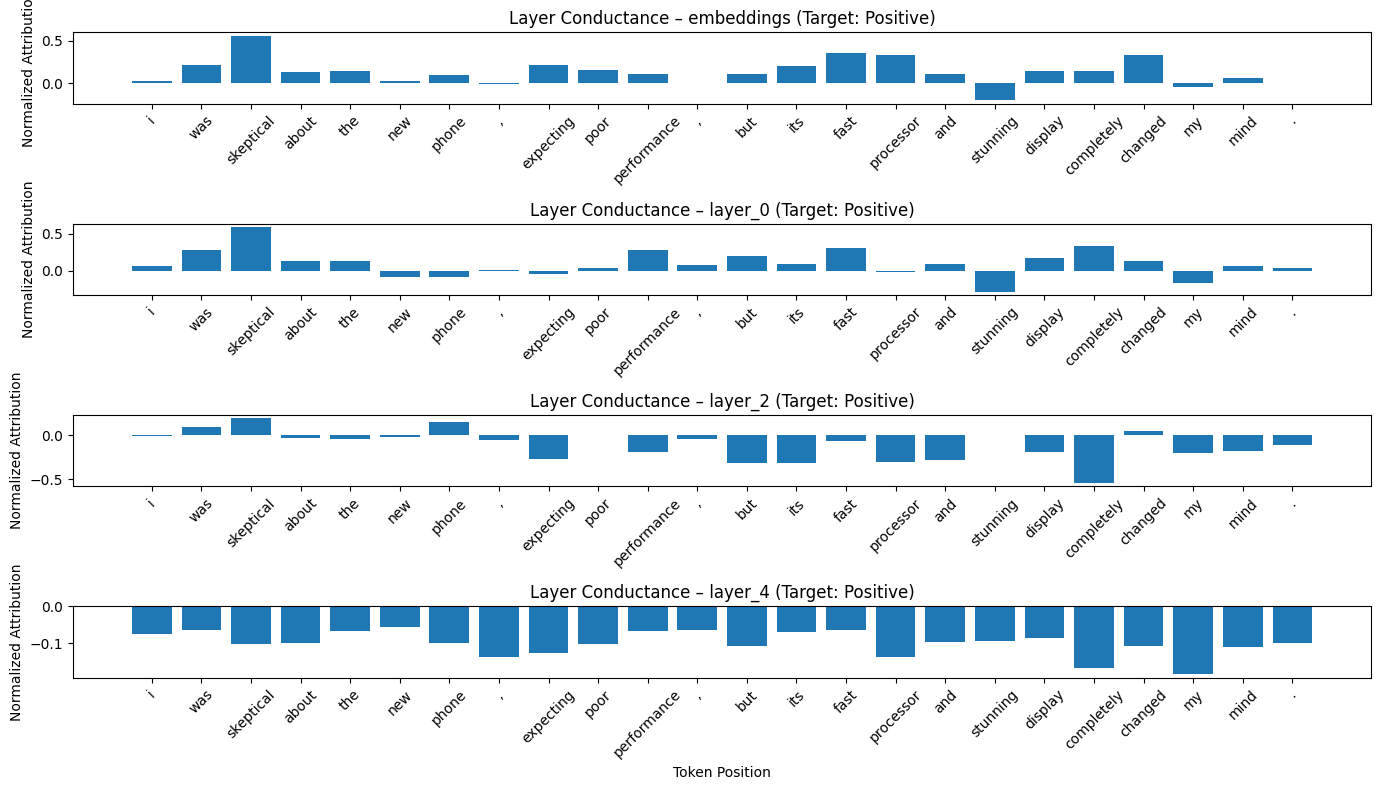

True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
Positive,Positive (embeddings) (0.98),Positive,3.21,"i was skeptical about the new phone , expecting poor performance , but its fast processor and stunning display completely changed my mind ."
Positive,Positive (layer_0) (0.98),Positive,2.32,"i was skeptical about the new phone , expecting poor performance , but its fast processor and stunning display completely changed my mind ."
Positive,Positive (layer_2) (0.98),Positive,-2.68,"i was skeptical about the new phone , expecting poor performance , but its fast processor and stunning display completely changed my mind ."
Positive,Positive (layer_4) (0.98),Positive,-2.38,"i was skeptical about the new phone , expecting poor performance , but its fast processor and stunning display completely changed my mind ."


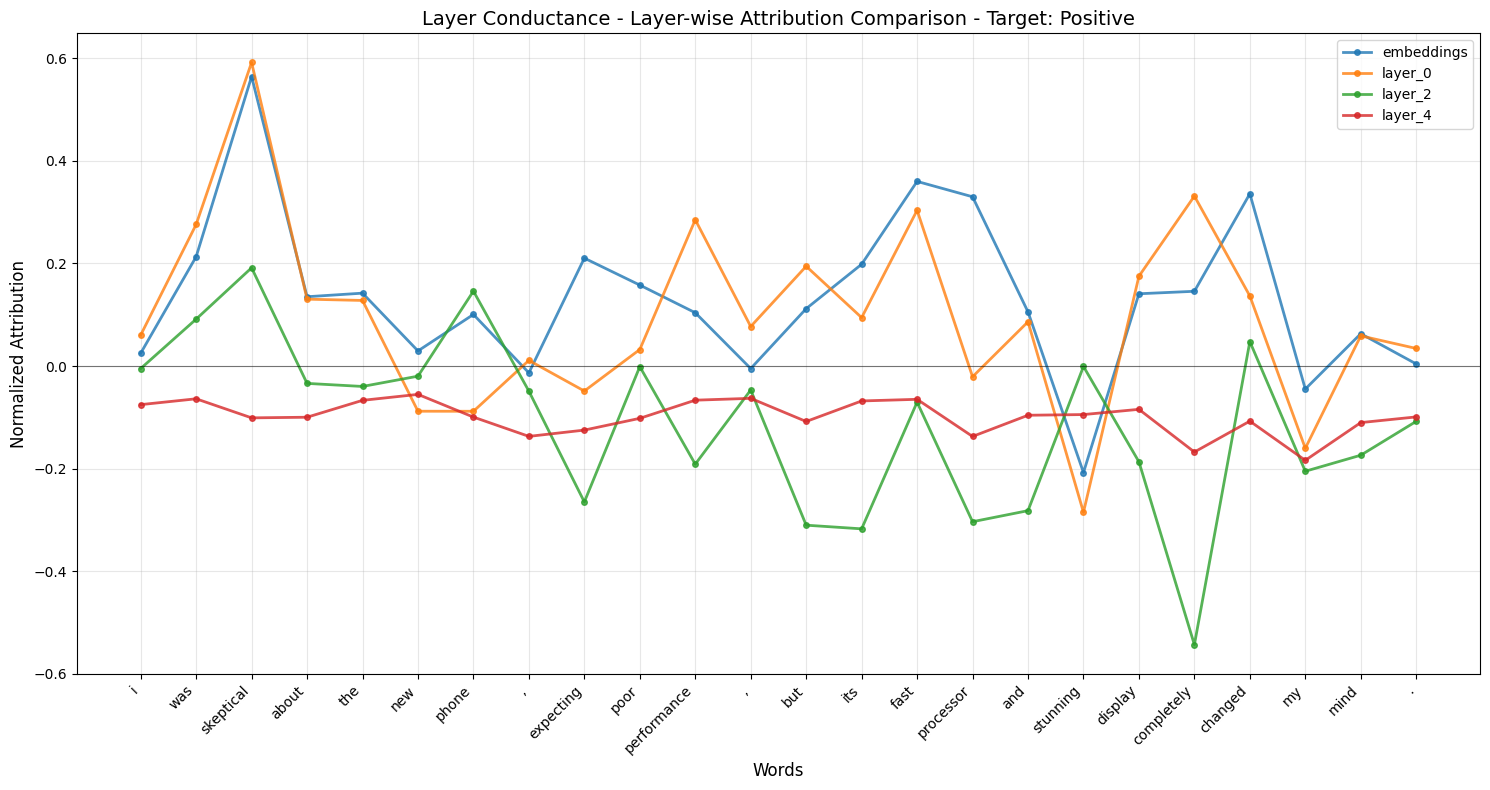


[Infidelity on Embedding Inputs via Layer Conductance]
  Infidelity: 0.003379
  Noise Level: 0.1
  Perturbation Samples: 20


In [ ]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
from captum.attr import LayerConductance
from captum.metrics import infidelity
from captum.attr import visualization as viz

class LayerConductanceAnalyzer:
    def __init__(self, model, tokenizer, label_names):
        self.model = model
        self.tokenizer = tokenizer
        self.label_names = label_names
        self.layer_dict = {
            "embeddings": model.distilbert.embeddings,
            "layer_0": model.distilbert.transformer.layer[0],
            "layer_2": model.distilbert.transformer.layer[2],
            "layer_4": model.distilbert.transformer.layer[4],
        }

    def preprocess(self, text):
        """Preprocess text for model input"""
        return self.tokenizer(
            text,
            return_tensors="pt",
            padding=True,
            truncation=True,
            max_length=512
        )

    def forward_func(self, input_ids, attention_mask):
        """Standard forward function using input_ids"""
        input_ids = input_ids.long()
        outputs = self.model(input_ids=input_ids, attention_mask=attention_mask)
        return F.softmax(outputs.logits, dim=-1)

    def forward_embeds(self, inputs_embeds, attention_mask):
        """Forward function that accepts embeddings directly"""
        outputs = self.model(inputs_embeds=inputs_embeds, attention_mask=attention_mask)
        return F.softmax(outputs.logits, dim=-1)

    def get_layerwise_attributions(self, text, target_label):
        """Get Layer Conductance attributions for all specified layers"""
        inputs = self.preprocess(text)
        input_ids = inputs["input_ids"].long()
        attention_mask = inputs["attention_mask"]

        results = {}

        for layer_name, layer in self.layer_dict.items():
            lc = LayerConductance(self.forward_func, layer)
            attributions = lc.attribute(
                inputs=input_ids,
                additional_forward_args=(attention_mask,),
                target=target_label
            )
            # Sum across hidden dimension and normalize
            attr_sum = attributions.sum(dim=-1).squeeze(0)
            attr_norm = attr_sum / torch.norm(attr_sum)

            results[layer_name] = {
                "attributions": attributions,  # Keep original for infidelity
                "normalized_attributions": attr_norm,
                "token_level_attributions": attr_norm.detach().cpu().numpy()
            }

        return results, input_ids, attention_mask

    def visualize_multiple_layers(self, results, input_ids, attention_mask, target_label):
        """Visualize attributions for all layers"""
        tokens = self.tokenizer.convert_ids_to_tokens(input_ids[0])
        probs = self.forward_func(input_ids, attention_mask)
        pred_label = torch.argmax(probs, dim=1).item()
        pred_score = torch.max(probs).item()

        # Create matplotlib visualization
        plt.figure(figsize=(14, 8))
        for i, (layer_name, result) in enumerate(results.items()):
            plt.subplot(len(results), 1, i+1)
            attributions = result["token_level_attributions"]

            # Filter out special tokens for matplotlib visualization
            filtered_tokens = []
            filtered_attrs = []
            for token, attr in zip(tokens, attributions):
                if token not in ["[CLS]", "[SEP]", "[PAD]"]:
                    filtered_tokens.append(token)
                    filtered_attrs.append(attr)

            plt.bar(range(len(filtered_tokens)), filtered_attrs)
            plt.xticks(range(len(filtered_tokens)), filtered_tokens, rotation=45)
            plt.title(f"Layer Conductance – {layer_name} (Target: {self.label_names[target_label]})")
            plt.ylabel("Normalized Attribution")
        plt.xlabel("Token Position")
        plt.tight_layout()
        plt.show()

        # Create Captum visualization records
        vis_records = []

        for layer_name, result in results.items():
            # Filter out special tokens for captum visualization
            filtered_tokens = []
            filtered_attrs = []
            for token, attr in zip(tokens, result["token_level_attributions"]):
                if token not in ["[CLS]", "[SEP]", "[PAD]"]:
                    filtered_tokens.append(token)
                    filtered_attrs.append(attr.item() if hasattr(attr, 'item') else attr)

            vis_records.append(
                viz.VisualizationDataRecord(
                    filtered_attrs,
                    pred_score,
                    f"{self.label_names[pred_label]} ({layer_name})",
                    self.label_names[target_label],
                    self.label_names[target_label],
                    sum(filtered_attrs),
                    filtered_tokens,
                    0.0  # No convergence delta for Layer Conductance
                )
            )

        viz.visualize_text(vis_records)

    def plot_layerwise_attributions(self, results, input_ids, target_label):
        """Plot line graph showing normalized attributions across layers"""
        tokens = self.tokenizer.convert_ids_to_tokens(input_ids[0])

        # Filter out special tokens first
        filtered_tokens = []
        filtered_indices = []
        for i, token in enumerate(tokens):
            if token not in ["[CLS]", "[SEP]", "[PAD]"]:
                filtered_tokens.append(token)
                filtered_indices.append(i)

        # Define colors for each layer (visually distinct)
        colors = {
            "embeddings": "#1f77b4",  # Blue
            "layer_0": "#ff7f0e",     # Orange
            "layer_2": "#2ca02c",     # Green
            "layer_4": "#d62728"      # Red
        }

        plt.figure(figsize=(15, 8))

        for layer_name, result in results.items():
            # Get normalized attributions
            attributions = result["token_level_attributions"]

            # Filter attributions for non-special tokens
            filtered_attrs = [attributions[i] for i in filtered_indices]

            # Plot line for this layer
            plt.plot(range(len(filtered_tokens)), filtered_attrs,
                    color=colors[layer_name], marker='o', linewidth=2,
                    markersize=4, label=layer_name, alpha=0.8)

        plt.xlabel('Words', fontsize=12)
        plt.ylabel('Normalized Attribution', fontsize=12)
        plt.title(f'Layer Conductance - Layer-wise Attribution Comparison - Target: {self.label_names[target_label]}', fontsize=14)
        plt.xticks(range(len(filtered_tokens)), filtered_tokens, rotation=45, ha='right')
        plt.legend(fontsize=10)
        plt.grid(True, alpha=0.3)
        plt.axhline(y=0, color='black', linestyle='-', alpha=0.5, linewidth=0.8)
        plt.tight_layout()
        plt.show()

    def compute_infidelity_on_embeddings(self, text, target_label, noise_level=0.1, n_perturb_samples=20):
        """
        Compute infidelity metric on embeddings layer

        Args:
            text: Input text
            target_label: Target class label
            noise_level: Standard deviation of noise for perturbations
            n_perturb_samples: Number of perturbation samples for infidelity computation
        """
        inputs = self.preprocess(text)
        input_ids = inputs["input_ids"].long()
        attention_mask = inputs["attention_mask"]

        # Convert input_ids to embeddings
        embedding_layer = self.model.distilbert.embeddings
        embeds = embedding_layer(input_ids)

        # Get Layer Conductance attributions on embeddings layer
        lc = LayerConductance(self.forward_embeds, embedding_layer)
        attributions = lc.attribute(
            inputs=embeds,
            additional_forward_args=(attention_mask,),
            target=target_label
        )

        # Define perturbation function
        def perturb_fn(x):
            """Add Gaussian noise to embeddings"""
            noise = torch.randn_like(x) * noise_level
            return noise, x + noise

        # Compute infidelity
        infid = infidelity(
            forward_func=self.forward_embeds,
            perturb_func=perturb_fn,
            inputs=embeds,
            attributions=attributions,
            additional_forward_args=(attention_mask,),
            target=target_label,
            n_perturb_samples=n_perturb_samples
        )

        print(f"\n[Infidelity on Embedding Inputs via Layer Conductance]")
        print(f"  Infidelity: {infid.item():.6f}")
        print(f"  Noise Level: {noise_level}")
        print(f"  Perturbation Samples: {n_perturb_samples}")

        return infid.item()

    def run_analysis(self, text, target_label):
        """Run complete attribution analysis"""
        print(f"Analyzing text: '{text}'")
        print(f"Target label: {self.label_names[target_label]}")

        # Get layerwise attributions
        results, input_ids, attention_mask = self.get_layerwise_attributions(text, target_label)

        # Visualize attributions
        self.visualize_multiple_layers(results, input_ids, attention_mask, target_label)

        # Plot layerwise attribution comparison
        self.plot_layerwise_attributions(results, input_ids, target_label)

        # Compute infidelity on embeddings
        infid_score = self.compute_infidelity_on_embeddings(text, target_label)

        return results, infid_score

# Usage example:
analyzer = LayerConductanceAnalyzer(model, tokenizer, label_names)
text = "I was skeptical about the new phone, expecting poor performance, but its fast processor and stunning display completely changed my mind."
target_label = 1
results, infidelity_score = analyzer.run_analysis(text, target_label)

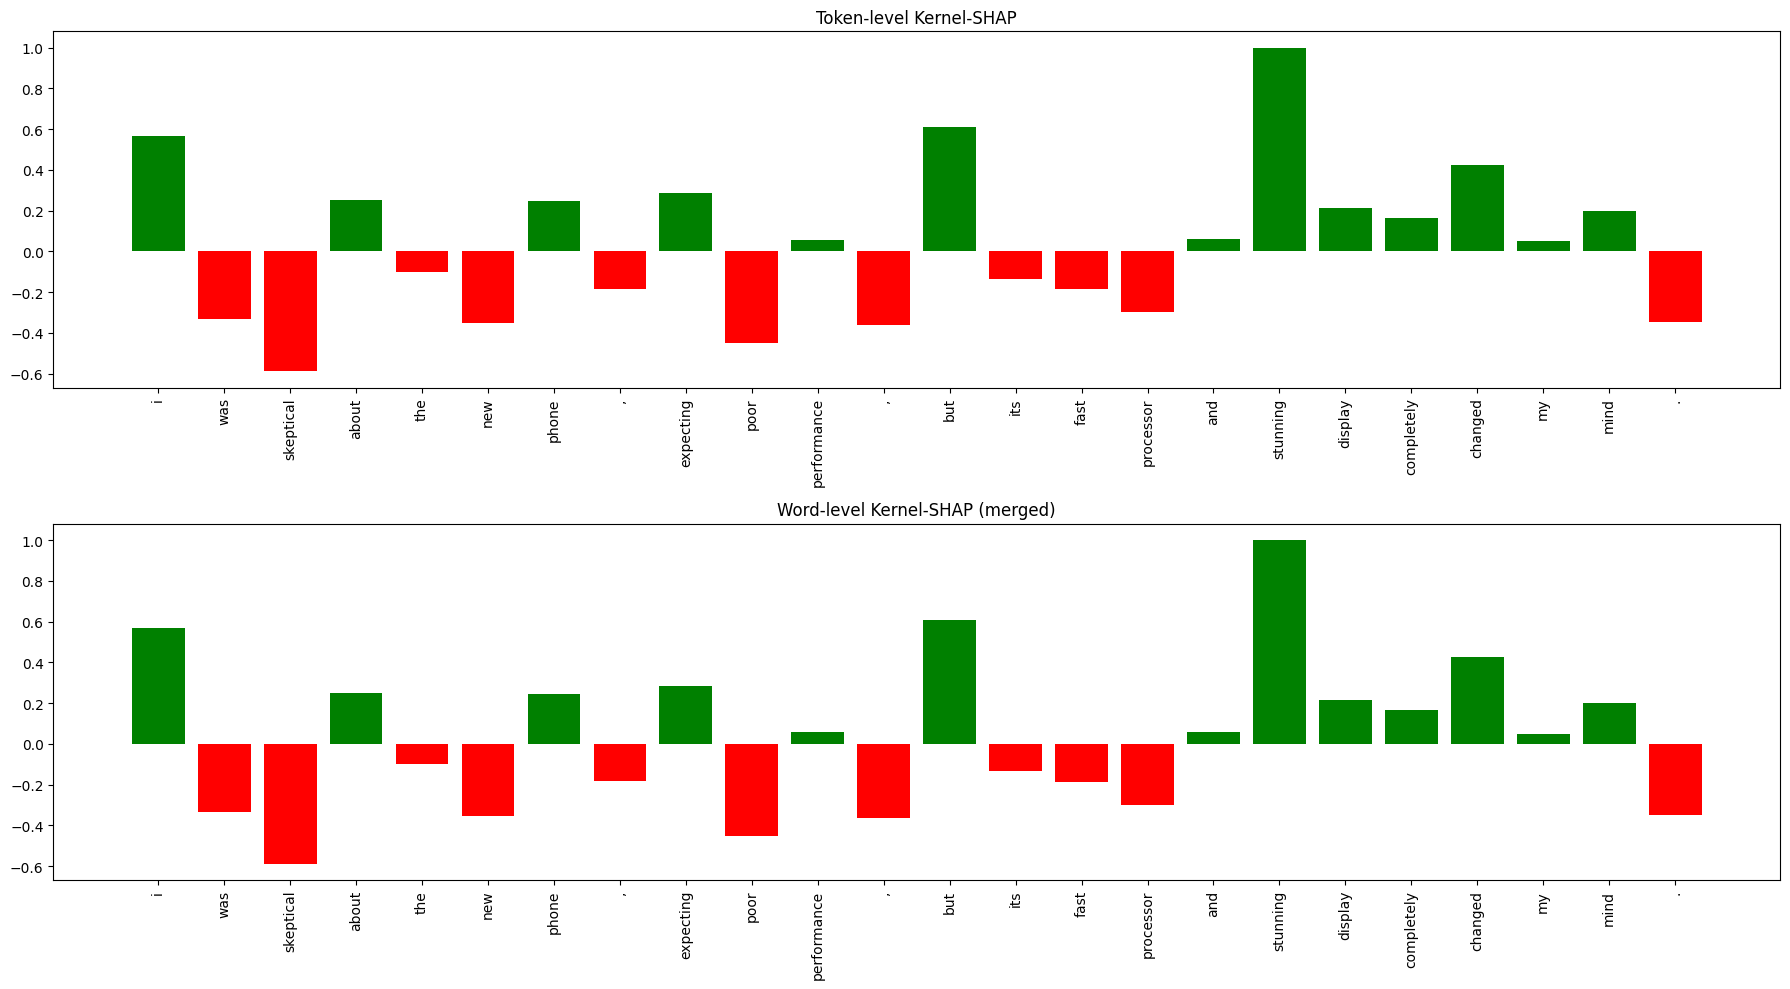


================ METRIC SUMMARY ================
Prediction                     : Positive (0.984)
Infidelity                     : 0.021536
Insertion  AUC                 : 0.430
Deletion   AUC                 : 0.226
Comprehensiveness (Δprob)      : 0.983
Sufficiency      (Δprob)       : 0.632



In [ ]:
import numpy as np
import torch, torch.nn.functional as F
import matplotlib.pyplot as plt
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from captum.attr import KernelShap
from captum.metrics import infidelity
from captum.attr import visualization as viz


class KernelShapAnalyzer:
    def __init__(self, model, tokenizer, label_names):
        self.model        = model.eval()
        self.tokenizer    = tokenizer
        self.label_names  = label_names
        self.cls_id       = tokenizer.cls_token_id
        self.sep_id       = tokenizer.sep_token_id or tokenizer.eos_token_id
        self.mask_id      = tokenizer.mask_token_id

    def preprocess(self, text):
        return self.tokenizer(
            text,
            return_tensors="pt",
            truncation=True,
            max_length=512,
        )

    def forward_softmax(self, **enc):
        with torch.no_grad():
            return F.softmax(self.model(**enc).logits, dim=-1)

    def _prepare_feature_encoding(self, enc):
        full_ids  = enc["input_ids"][0]
        sep_pos   = (full_ids == self.sep_id).nonzero(as_tuple=True)[0][0].item()
        feat_ids  = full_ids[1:sep_pos]
        feat_tokens = self.tokenizer.convert_ids_to_tokens(feat_ids)
        return feat_ids, feat_tokens

    def _masked_forward(self, feat_ids, mask):
        B = mask.size(0)
        masked = feat_ids.unsqueeze(0).repeat(B, 1).clone()
        masked[mask == 0] = self.mask_id

        cls = torch.full((B, 1), self.cls_id, dtype=torch.long)
        sep = torch.full((B, 1), self.sep_id, dtype=torch.long)
        ids = torch.cat([cls, masked, sep], dim=1)
        att = torch.ones_like(ids)

        logits = self.model(ids, attention_mask=att).logits
        return F.softmax(logits, dim=-1)

    def get_token_attributions(self, text):
        enc               = self.preprocess(text)
        feat_ids, tokens  = self._prepare_feature_encoding(enc)

        probs             = self.forward_softmax(**enc)
        pred_cls          = int(torch.argmax(probs))
        pred_prob         = float(probs[0, pred_cls])

        forward_fn        = lambda m: self._masked_forward(feat_ids, m)[:, pred_cls]

        ks                = KernelShap(forward_fn)
        baseline          = torch.zeros(1, len(tokens))
        inputs            = torch.ones(1, len(tokens))

        attr = ks.attribute(
            inputs,
            baselines=baseline,
            n_samples=100,
        )[0].cpu().numpy()

        return {
            "attributions": attr,
            "tokens": tokens,
            "inputs_mask": inputs,
            "forward_fn": forward_fn,
            "pred_cls": pred_cls,
            "pred_prob": pred_prob,
        }

    def _infidelity(self, info):
        return infidelity(
            forward_func=info["forward_fn"],
            perturb_func=lambda x: (
                torch.randn_like(x) * 0.1,
                x + torch.randn_like(x) * 0.1,
            ),
            inputs=info["inputs_mask"],
            attributions=torch.tensor(info["attributions"]).unsqueeze(0),
            n_perturb_samples=20,
        ).item()

    def _id_auc(self, scores, forward_fn, inputs_mask, steps=20):
        order = np.argsort(np.abs(scores))[::-1]
        ins, dele = [], []
        ins_mask = torch.zeros_like(inputs_mask)
        del_mask = torch.ones_like(inputs_mask)

        for k in range(steps + 1):
            ins.append(float(forward_fn(ins_mask)[0]))
            dele.append(float(forward_fn(del_mask)[0]))
            if k < len(order):
                ins_mask[0, order[k]] = 1
                del_mask[0, order[k]] = 0
        return np.trapz(ins) / steps, np.trapz(dele) / steps

    def _comp_suff(self, scores, forward_fn, inputs_mask, pred_prob, pct=0.20):
        k      = max(1, int(len(scores) * pct))
        top    = np.argsort(np.abs(scores))[::-1].copy()[:k]
        top_ix = torch.tensor(top, dtype=torch.long)

        comp_mask = inputs_mask.clone()
        comp_mask[0, top_ix] = 0
        comp = pred_prob - float(forward_fn(comp_mask)[0])

        suff_mask = torch.zeros_like(inputs_mask)
        suff_mask[0, top_ix] = 1
        suff = pred_prob - float(forward_fn(suff_mask)[0])
        return comp, suff

    @staticmethod
    def _merge_subwords(tokens, attrs):
        words, agg, cur_w, cur_a, cnt = [], [], "", 0, 0
        for t, a in zip(tokens, attrs):
            if t.startswith("##"):
                cur_w += t[2:]
                cur_a += a
                cnt   += 1
            else:
                if cur_w:
                    words.append(cur_w)
                    agg.append(cur_a / cnt)
                cur_w, cur_a, cnt = t, a, 1
        if cur_w:
            words.append(cur_w)
            agg.append(cur_a / cnt)
        return words, np.array(agg)

    def _plot_token_bars(self, tokens, token_attr, words, word_attr):
        attr_n  = token_attr / (np.abs(token_attr).max() + 1e-10)
        w_attr_n = word_attr / (np.abs(word_attr).max() + 1e-10)

        fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(18, 10))

        ax1.bar(range(len(attr_n)), attr_n,
                color=["red" if v < 0 else "green" for v in attr_n])
        ax1.set_xticks(range(len(tokens)))
        ax1.set_xticklabels(tokens, rotation=90, ha="center")
        ax1.set_title("Token-level Kernel-SHAP")

        ax2.bar(range(len(w_attr_n)), w_attr_n,
                color=["red" if v < 0 else "green" for v in w_attr_n])
        ax2.set_xticks(range(len(words)))
        ax2.set_xticklabels(words, rotation=90, ha="center")
        ax2.set_title("Word-level Kernel-SHAP (merged)")

        plt.tight_layout()
        plt.show()

        try:
            viz.visualize_text([
                viz.VisualizationDataRecord(
                    attr_n,
                    0.0,
                    "Kernel-SHAP Tokens",
                    "",
                    "",
                    attr_n.sum(),
                    " ".join(tokens),
                    None,
                )
            ])
            viz.visualize_text([
                viz.VisualizationDataRecord(
                    w_attr_n,
                    0.0,
                    "Kernel-SHAP Words",
                    "",
                    "",
                    w_attr_n.sum(),
                    " ".join(words),
                    None,
                )
            ])
        except Exception:
            pass

    def run_analysis(self, text):
        info = self.get_token_attributions(text)

        infid     = self._infidelity(info)
        ins_auc, del_auc = self._id_auc(
            info["attributions"], info["forward_fn"], info["inputs_mask"]
        )
        comp, suff = self._comp_suff(
            info["attributions"],
            info["forward_fn"],
            info["inputs_mask"],
            info["pred_prob"],
        )

        words, word_attr = self._merge_subwords(info["tokens"], info["attributions"])
        self._plot_token_bars(info["tokens"], info["attributions"], words, word_attr)

        print("\n================ METRIC SUMMARY ================")
        print(f"Prediction                     : "
              f"{self.label_names[info['pred_cls']]} ({info['pred_prob']:.3f})")
        print(f"Infidelity                     : {infid:.6f}")
        print(f"Insertion  AUC                 : {ins_auc:.3f}")
        print(f"Deletion   AUC                 : {del_auc:.3f}")
        print(f"Comprehensiveness (Δprob)      : {comp:.3f}")
        print(f"Sufficiency      (Δprob)       : {suff:.3f}")
        print("================================================\n")

        return {
            "token_attributions": info["attributions"],
            "word_attributions":  word_attr,
            "metrics": {
                "infidelity": infid,
                "insertion_auc": ins_auc,
                "deletion_auc": del_auc,
                "comprehensiveness": comp,
                "sufficiency": suff,
            },
        }

analyzer    = KernelShapAnalyzer(model, tokenizer, label_names)
sample_text = (
    "I was skeptical about the new phone, expecting poor performance, but its fast processor and stunning display completely changed my mind."
)
results = analyzer.run_analysis(sample_text)


Analyzing text: 'I was skeptical about the new phone, expecting poor performance, but its fast processor and stunning display completely changed my mind.'
Target label: Negative
Prediction: Positive (confidence 0.984)


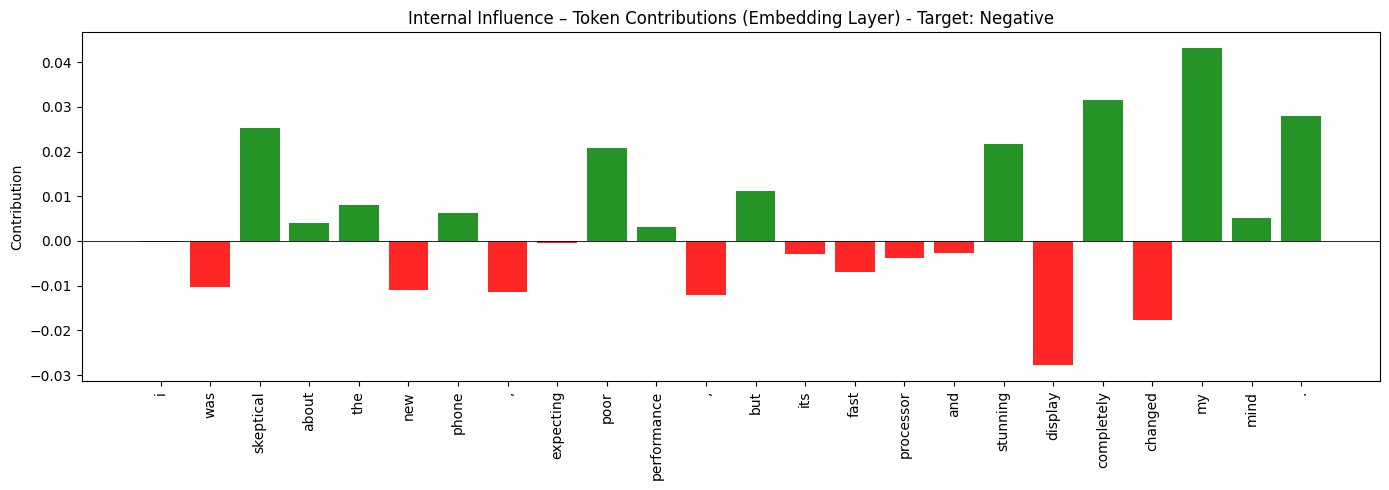

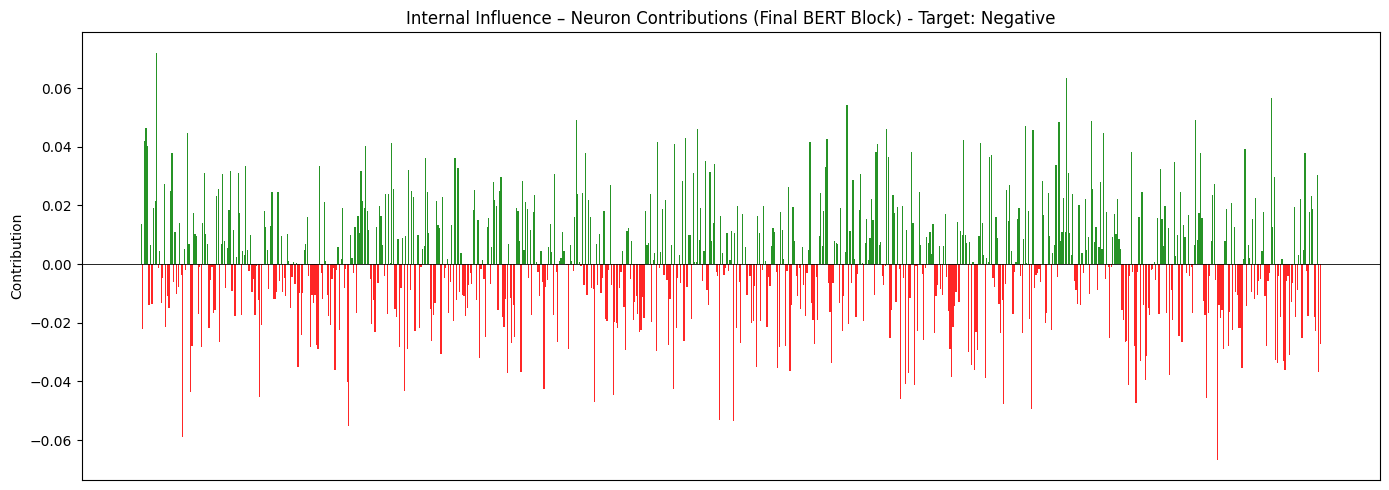


[Infidelity Metrics]
  Embedding Layer Infidelity: 0.002851
  Final Layer Infidelity: 0.002597
  Noise Level: 0.1
  Perturbation Samples: 20

[Insertion/Deletion AUC Metrics]
  Embedding Layer - Insertion AUC: 0.556 | Deletion AUC: 0.564
  Final Layer - Insertion AUC: 0.553 | Deletion AUC: 0.603

[Comprehensiveness & Sufficiency Metrics]
  Embedding Layer - Comprehensiveness: -0.502 | Sufficiency: -0.603
  Final Layer - Comprehensiveness: -0.481 | Sufficiency: -0.633


In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification
from captum.attr import InternalInfluence
from captum.metrics import infidelity

class InternalInfluenceAnalyzer:
    def __init__(self, model, tokenizer, label_names):
        self.model = model
        self.tokenizer = tokenizer
        self.label_names = label_names
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.model.to(self.device)

        # Create Captum wrapper
        self.captum_wrapper = self._create_captum_wrapper()

    def _create_captum_wrapper(self):
        """Create wrapper for Captum compatibility"""
        class BertCaptumWrapper(torch.nn.Module):
            def __init__(self, m):
                super().__init__()
                self.m = m
                self.emb = m.distilbert.embeddings
                self.last = m.distilbert.transformer.layer[-1]

            def forward(self, inputs_embeds, attention_mask=None):
                return self.m.distilbert(inputs_embeds=inputs_embeds,
                                       attention_mask=attention_mask).last_hidden_state

            def predict(self, inputs_embeds, attention_mask=None):
                return self.m.classifier(self.forward(inputs_embeds, attention_mask)[:, 0])

        return BertCaptumWrapper(self.model)

    def preprocess(self, text):
        """Preprocess text for model input"""
        return self.tokenizer(
            text,
            return_tensors="pt",
            truncation=True,
            padding=True,
            max_length=512
        )

    def forward_func(self, input_ids, attention_mask):
        """Standard forward function using input_ids"""
        input_ids = input_ids.long()
        outputs = self.model(input_ids=input_ids, attention_mask=attention_mask)
        return torch.softmax(outputs.logits, dim=-1)

    def get_internal_influence_attributions(self, text, target_label):
        """Get Internal Influence attributions for embedding and final layers"""
        inputs = self.preprocess(text)
        input_ids = inputs["input_ids"].to(self.device)
        attention_mask = inputs["attention_mask"].to(self.device)

        # Get embeddings
        with torch.no_grad():
            embeds = self.model.distilbert.embeddings(input_ids)

        # Get prediction
        with torch.no_grad():
            logits = self.model(input_ids, attention_mask=attention_mask).logits
            probs = torch.softmax(logits, -1)
            pred = int(torch.argmax(probs))

        # Internal Influence function
        def internal_inf(layer):
            base = torch.zeros_like(embeds)
            ii = InternalInfluence(self.captum_wrapper.predict, layer)
            return ii.attribute(embeds, baselines=base,
                              additional_forward_args=(attention_mask,), target=target_label)

        # Get attributions for both layers
        attr_emb = internal_inf(self.captum_wrapper.emb)           # [1, seq, 768]
        attr_last_full = internal_inf(self.captum_wrapper.last)     # [1, seq, 768]

        # Process attributions
        token_scores = attr_emb.sum(-1).squeeze(0)          # [seq]
        token_scores_L = attr_last_full.sum(-1).squeeze(0)   # [seq]
        neuron_scores = attr_last_full.sum(1).squeeze(0)     # [768]

        results = {
            "embedding_layer": {
                "attributions": attr_emb,
                "token_level_attributions": token_scores.detach().cpu().numpy(),
                "raw_attributions": attr_emb
            },
            "final_layer": {
                "attributions": attr_last_full,
                "token_level_attributions": token_scores_L.detach().cpu().numpy(),
                "neuron_level_attributions": neuron_scores.detach().cpu().numpy(),
                "raw_attributions": attr_last_full
            }
        }

        return results, input_ids, attention_mask, embeds, probs, pred

    def visualize_multiple_layers(self, results, input_ids, attention_mask, target_label):
        """Visualize attributions for both layers"""
        tokens = self.tokenizer.convert_ids_to_tokens(input_ids[0])
        probs = self.forward_func(input_ids, attention_mask)
        pred_label = torch.argmax(probs, dim=1).item()
        pred_score = torch.max(probs).item()

        # Filter out special tokens
        special_tokens = ['[CLS]', '[SEP]', '[PAD]', '[UNK]', '[MASK]']

        def filter_special_tokens(tokens, values):
            """Filter out special tokens and their corresponding values"""
            filtered_tokens = []
            filtered_values = []

            for i, token in enumerate(tokens):
                if token not in special_tokens:
                    filtered_tokens.append(token)
                    filtered_values.append(values[i])

            return filtered_tokens, np.array(filtered_values)

        # Token-level visualizations
        def create_bar_plot(vals, labels, title, ylabel, hide_xticks=False):
            # Filter out special tokens
            filtered_labels, filtered_vals = filter_special_tokens(labels, vals)

            v = filtered_vals if isinstance(filtered_vals, np.ndarray) else filtered_vals.cpu().numpy()
            colors = ["green" if x >= 0 else "red" for x in v]
            plt.figure(figsize=(14, 5))
            plt.bar(range(len(v)), v, color=colors, alpha=.85)
            plt.axhline(0, color="k", lw=.6)
            plt.title(title)
            plt.ylabel(ylabel)
            if hide_xticks:
                plt.xticks([])
            else:
                plt.xticks(range(len(v)), filtered_labels, rotation=90, ha="center")
            plt.tight_layout()
            plt.show()

        # Plot embedding layer token contributions
        create_bar_plot(
            results["embedding_layer"]["token_level_attributions"],
            tokens,
            f"Internal Influence – Token Contributions (Embedding Layer) - Target: {self.label_names[target_label]}",
            "Contribution"
        )

        # Plot neuron contributions (this doesn't need filtering as it's neuron-level, not token-level)
        vals = results["final_layer"]["neuron_level_attributions"]
        v = vals if isinstance(vals, np.ndarray) else vals.cpu().numpy()
        colors = ["green" if x >= 0 else "red" for x in v]
        plt.figure(figsize=(14, 5))
        plt.bar(range(len(v)), v, color=colors, alpha=.85)
        plt.axhline(0, color="k", lw=.6)
        plt.title(f"Internal Influence – Neuron Contributions (Final BERT Block) - Target: {self.label_names[target_label]}")
        plt.ylabel("Contribution")
        plt.xticks([])
        plt.tight_layout()
        plt.show()

    def compute_infidelity_metrics(self, embeds, attention_mask, target_label, results):
        """Compute infidelity metrics for both layers"""
        def infid(attrs):
            def perturb(x):
                noise = torch.randn_like(x) * 0.1
                return noise, x + noise
            return infidelity(self.captum_wrapper.predict, perturb, embeds, attrs,
                            additional_forward_args=(attention_mask,), target=target_label, n_perturb_samples=20)

        infid_emb = infid(results["embedding_layer"]["attributions"]).item()
        infid_last = infid(results["final_layer"]["attributions"]).item()

        print(f"\n[Infidelity Metrics]")
        print(f"  Embedding Layer Infidelity: {infid_emb:.6f}")
        print(f"  Final Layer Infidelity: {infid_last:.6f}")
        print(f"  Noise Level: 0.1")
        print(f"  Perturbation Samples: 20")

        return {"embedding_layer": infid_emb, "final_layer": infid_last}

    def compute_insertion_deletion_auc(self, embeds, attention_mask, target_label, results):
        """Compute insertion/deletion AUC for both layers"""
        def insertion_deletion_auc(scores, steps=20):
            ranks = torch.argsort(scores.abs(), descending=True)
            total = scores.size(0)

            def conf(mask_bool):
                temp = embeds.clone()
                temp[:, ~mask_bool, :] = 0
                return self.captum_wrapper.predict(temp, attention_mask=attention_mask).softmax(-1)[0, target_label].item()

            # deletion curve
            del_mask = torch.ones(total, dtype=torch.bool, device=self.device)
            del_curve = []
            for k in range(steps + 1):
                del_curve.append(conf(del_mask))
                if k < total:
                    del_mask[ranks[k]] = False
            del_auc = torch.trapz(torch.tensor(del_curve)).item() / steps

            # insertion curve
            ins_mask = torch.zeros(total, dtype=torch.bool, device=self.device)
            ins_curve = []
            for k in range(steps + 1):
                ins_curve.append(conf(ins_mask))
                if k < total:
                    ins_mask[ranks[k]] = True
            ins_auc = torch.trapz(torch.tensor(ins_curve)).item() / steps
            return ins_auc, del_auc

        # Get scores as tensors
        token_scores = torch.tensor(results["embedding_layer"]["token_level_attributions"], device=self.device)
        token_scores_L = torch.tensor(results["final_layer"]["token_level_attributions"], device=self.device)

        ins_emb, del_emb = insertion_deletion_auc(token_scores)
        ins_last, del_last = insertion_deletion_auc(token_scores_L)

        print(f"\n[Insertion/Deletion AUC Metrics]")
        print(f"  Embedding Layer - Insertion AUC: {ins_emb:.3f} | Deletion AUC: {del_emb:.3f}")
        print(f"  Final Layer - Insertion AUC: {ins_last:.3f} | Deletion AUC: {del_last:.3f}")

        return {
            "embedding_layer": {"insertion_auc": ins_emb, "deletion_auc": del_emb},
            "final_layer": {"insertion_auc": ins_last, "deletion_auc": del_last}
        }

    def compute_comprehensiveness_sufficiency(self, embeds, attention_mask, target_label, results, probs):
        """Compute comprehensiveness and sufficiency metrics"""
        def comp_suff(scores, top_pct=0.20):
            k = max(1, int(scores.size(0) * top_pct))
            top_idx = torch.argsort(scores.abs(), descending=True)[:k]

            base_conf = probs[0, target_label].item()

            # comprehensiveness (remove top)
            comp_mask = torch.ones_like(scores, dtype=torch.bool, device=self.device)
            comp_mask[top_idx] = False
            comp_embed = embeds.clone()
            comp_embed[:, comp_mask, :] = 0
            comp_conf = self.captum_wrapper.predict(comp_embed, attention_mask=attention_mask).softmax(-1)[0, target_label].item()
            comprehensiveness = base_conf - comp_conf

            # sufficiency (keep only top)
            suff_mask = torch.zeros_like(scores, dtype=torch.bool, device=self.device)
            suff_mask[top_idx] = True
            suff_embed = embeds.clone()
            suff_embed[:, suff_mask, :] = 0
            suff_conf = self.captum_wrapper.predict(suff_embed, attention_mask=attention_mask).softmax(-1)[0, target_label].item()
            sufficiency = base_conf - suff_conf
            return comprehensiveness, sufficiency

        # Get scores as tensors
        token_scores = torch.tensor(results["embedding_layer"]["token_level_attributions"], device=self.device)
        token_scores_L = torch.tensor(results["final_layer"]["token_level_attributions"], device=self.device)

        comp_emb, suff_emb = comp_suff(token_scores)
        comp_last, suff_last = comp_suff(token_scores_L)

        print(f"\n[Comprehensiveness & Sufficiency Metrics]")
        print(f"  Embedding Layer - Comprehensiveness: {comp_emb:.3f} | Sufficiency: {suff_emb:.3f}")
        print(f"  Final Layer - Comprehensiveness: {comp_last:.3f} | Sufficiency: {suff_last:.3f}")

        return {
            "embedding_layer": {"comprehensiveness": comp_emb, "sufficiency": suff_emb},
            "final_layer": {"comprehensiveness": comp_last, "sufficiency": suff_last}
        }

    def run_analysis(self, text, target_label):
        """Run complete Internal Influence analysis"""
        print(f"Analyzing text: '{text}'")
        print(f"Target label: {self.label_names[target_label]}")

        # Get attributions
        results, input_ids, attention_mask, embeds, probs, pred = self.get_internal_influence_attributions(text, target_label)

        print(f"Prediction: {self.label_names[pred]} (confidence {probs[0, pred]:.3f})")

        # Visualize attributions
        self.visualize_multiple_layers(results, input_ids, attention_mask, target_label)

        # Compute all metrics
        infidelity_scores = self.compute_infidelity_metrics(embeds, attention_mask, target_label, results)
        insertion_deletion_scores = self.compute_insertion_deletion_auc(embeds, attention_mask, target_label, results)
        comp_suff_scores = self.compute_comprehensiveness_sufficiency(embeds, attention_mask, target_label, results, probs)

        all_metrics = {
            "infidelity": infidelity_scores,
            "insertion_deletion": insertion_deletion_scores,
            "comprehensiveness_sufficiency": comp_suff_scores
        }

        return results, all_metrics

analyzer = InternalInfluenceAnalyzer(model, tokenizer, label_names)
text = "I was skeptical about the new phone, expecting poor performance, but its fast processor and stunning display completely changed my mind."
target_label = 0  # or 1
results, metrics = analyzer.run_analysis(text, target_label)


🔍 Analyzing: I was skeptical about the new phone, expecting poor performance, but its fast processor and stunning display completely changed my mind.


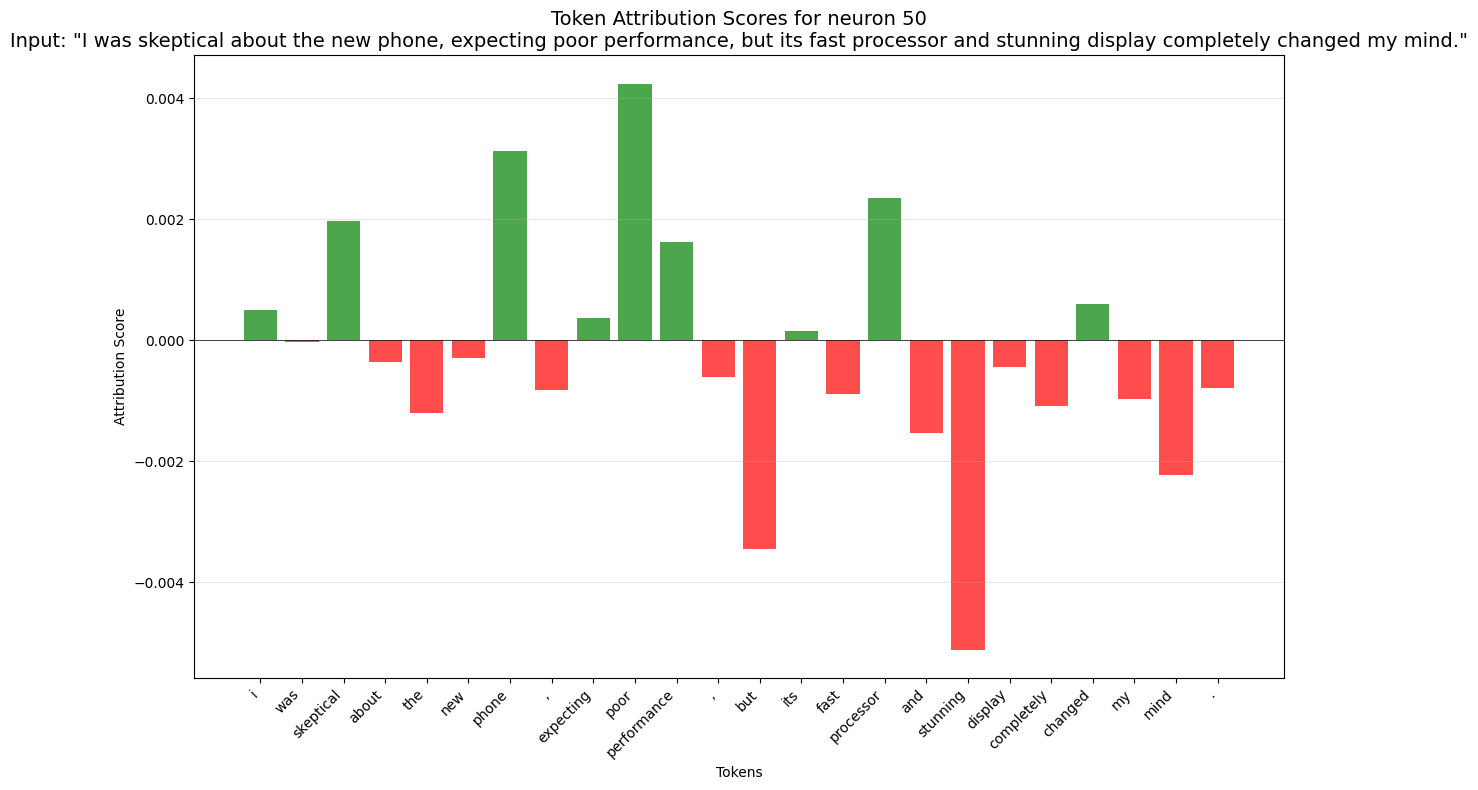

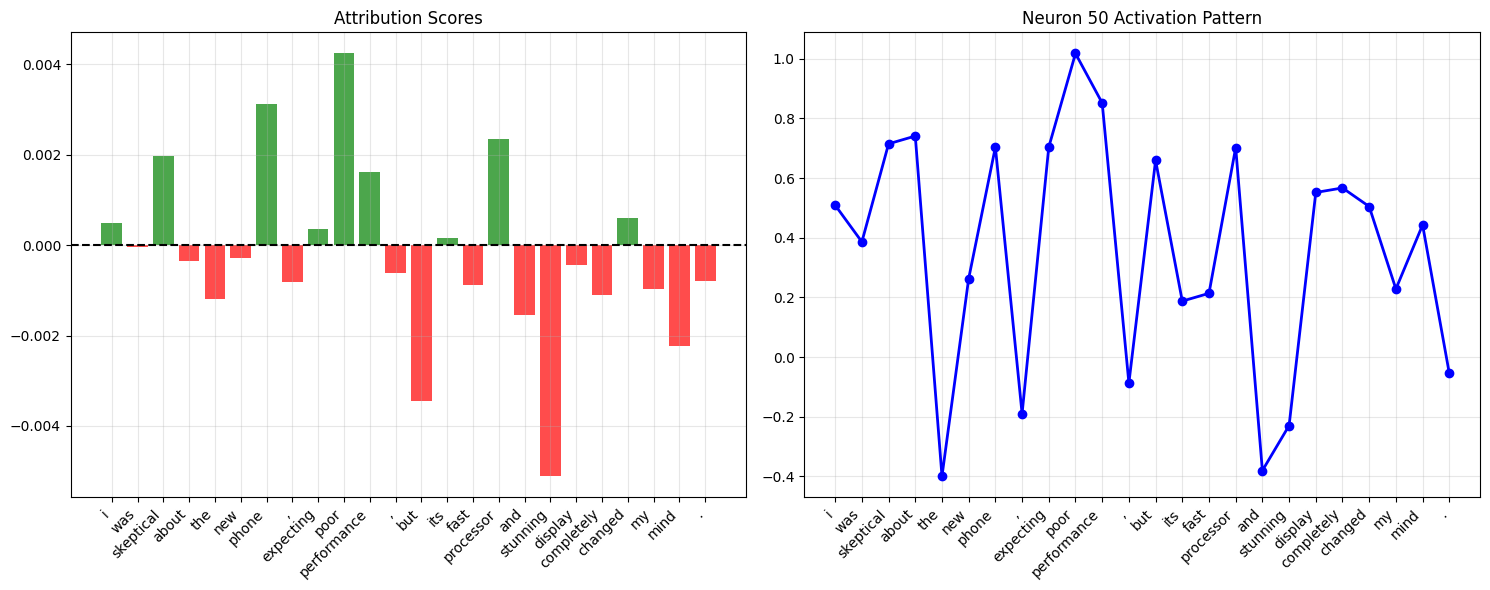

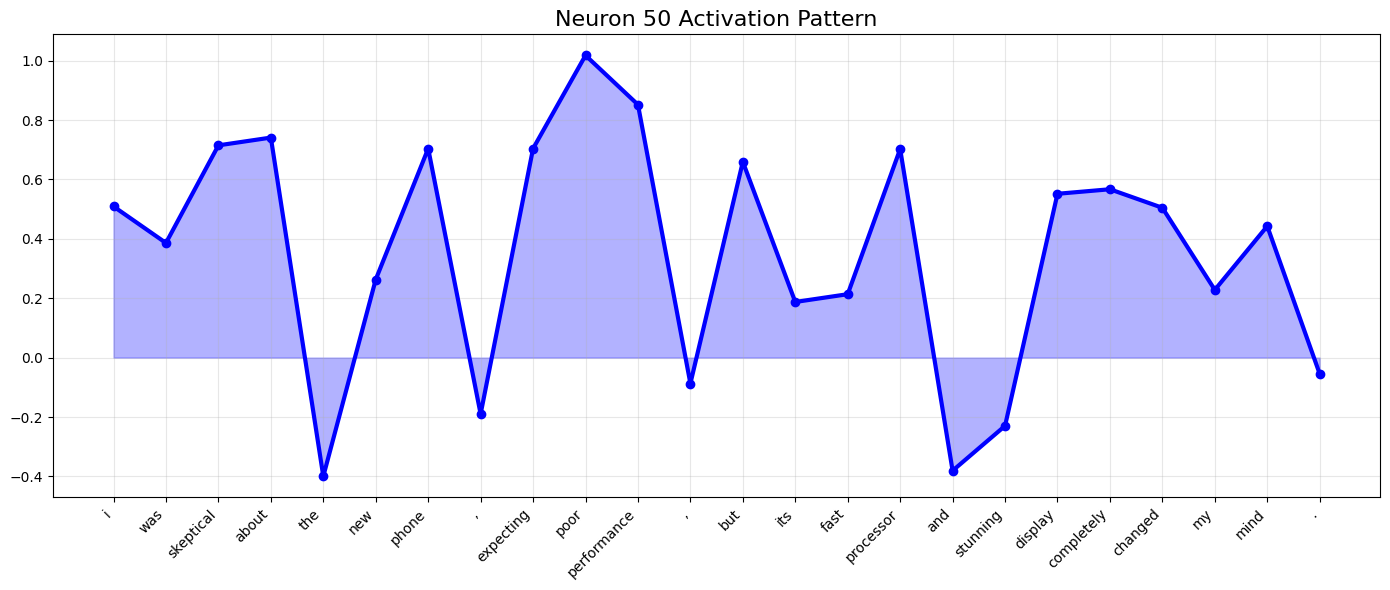

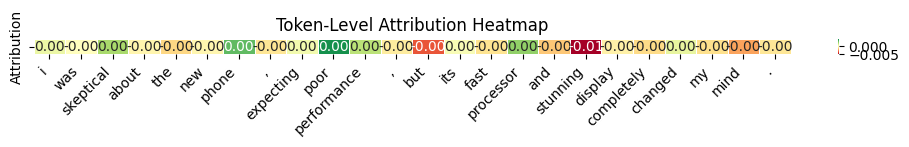


🧠 Neuron Conductance Attribution Summary
Token                Score      Activation    Contribution to Neuron
---------------------------------------------------------------------------
i               +0.000497 +0.509127                 increases activation of neuron 50
was             -0.000033 +0.386167                 decreases activation of neuron 50
skeptical       +0.001964 +0.714916                 increases activation of neuron 50
about           -0.000362 +0.741048                 decreases activation of neuron 50
the             -0.001196 -0.399680                 decreases activation of neuron 50
new             -0.000294 +0.263080                 decreases activation of neuron 50
phone           +0.003120 +0.703959                 increases activation of neuron 50
,               -0.000823 -0.189830                 decreases activation of neuron 50
expecting       +0.000361 +0.704016                 increases activation of neuron 50
poor            +0.004241 +1.017908    

In [2]:
#Neuron Conductance Optimized

import torch
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification
from captum.attr import NeuronConductance
from math import pi
import re

class NeuronConductanceAnalyzer:
    def __init__(self, model, tokenizer, label_names):
        self.model = model
        self.tokenizer = tokenizer
        self.label_names = label_names
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.model.to(self.device).eval()

        # Verify pre_classifier is a torch module
        assert isinstance(self.model.pre_classifier, torch.nn.Module), "pre_classifier must be an nn.Module"

    def preprocess(self, text):
        inputs = self.tokenizer(text, return_tensors="pt", padding=True, truncation=True)
        return {k: v.to(self.device) for k, v in inputs.items()}

    def forward_from_embeddings(self, input_embeds, attention_mask):
        input_embeds.requires_grad_()  # Ensure gradient tracking
        extended_mask = attention_mask.unsqueeze(1).unsqueeze(2).to(dtype=input_embeds.dtype)
        extended_mask = (1.0 - extended_mask) * -10000.0

        transformer_output = self.model.distilbert.transformer(
            input_embeds,
            extended_mask,
            head_mask=[None] * len(self.model.distilbert.transformer.layer),
            output_attentions=False,
            output_hidden_states=False,
            return_dict=True
        )

        pooled = transformer_output.last_hidden_state[:, 0, :]
        hidden = self.model.pre_classifier(pooled)
        hidden = F.relu(hidden)
        logits = self.model.classifier(hidden)
        return logits

    @torch.no_grad()
    def compute_neuron_activations_per_token(self, input_ids, attention_mask, neuron_idx):
        embeds = self.model.distilbert.embeddings(input_ids)
        seq_len = input_ids.size(1)
        neuron_activations = []

        for token_pos in range(seq_len):
            masked_embeds = embeds.clone()
            mask = torch.zeros_like(embeds)
            mask[:, token_pos, :] = 1
            masked_embeds = masked_embeds * mask

            extended_mask = attention_mask.unsqueeze(1).unsqueeze(2).to(dtype=embeds.dtype)
            extended_mask = (1.0 - extended_mask) * -10000.0

            transformer_output = self.model.distilbert.transformer(
                masked_embeds,
                extended_mask,
                head_mask=[None] * len(self.model.distilbert.transformer.layer),
                output_attentions=False,
                output_hidden_states=False,
                return_dict=True
            )

            pooled = transformer_output.last_hidden_state[:, 0, :]
            hidden = self.model.pre_classifier(pooled)
            neuron_activation = hidden.squeeze(0)[neuron_idx].item()
            neuron_activations.append(neuron_activation)

        return neuron_activations

    def compute_attributions(self, input_ids, attention_mask, target_class, neuron_idx=50):
        embeds = self.model.distilbert.embeddings(input_ids).detach().clone().requires_grad_()
        target_layer = self.model.pre_classifier

        nc = NeuronConductance(self.forward_from_embeddings, target_layer)
        attributions = nc.attribute(
            inputs=embeds,
            neuron_selector=neuron_idx,
            additional_forward_args=(attention_mask,),
            target=target_class,
            n_steps=25,
            internal_batch_size=1
        )

        with torch.no_grad():
            transformer_output = self.model.distilbert.transformer(
                embeds,
                attention_mask.unsqueeze(1).unsqueeze(2).to(dtype=embeds.dtype),
                head_mask=[None] * len(self.model.distilbert.transformer.layer),
                output_attentions=False,
                output_hidden_states=False,
                return_dict=True
            )

            pooled = transformer_output.last_hidden_state[:, 0, :]
            hidden = self.model.pre_classifier(pooled)
            activation = hidden.squeeze(0)[neuron_idx]

        return attributions, activation.unsqueeze(0), embeds

    def clean_tokens_scores(self, input_ids, attributions):
        raw_tokens = self.tokenizer.convert_ids_to_tokens(input_ids[0])
        token_attrs = attributions.sum(dim=-1).squeeze(0).detach().cpu().numpy()

        clean_tokens, clean_scores = [], []
        temp_token, temp_score, accumulating = "", 0.0, False

        for token, score in zip(raw_tokens, token_attrs):
            if token in ["[CLS]", "[SEP]", "[PAD]"]:
                continue
            if token.startswith("##"):
                temp_token += token[2:]
                temp_score += score
            else:
                if accumulating:
                    clean_tokens.append(temp_token)
                    clean_scores.append(temp_score)
                temp_token = token
                temp_score = score
                accumulating = True
        if temp_token:
            clean_tokens.append(temp_token)
            clean_scores.append(temp_score)

        return clean_tokens, clean_scores, token_attrs, raw_tokens

    def visualize(self, clean_tokens, clean_scores, token_attrs, raw_tokens, text, target_label_name, pred_class, target_neuron_activation, neuron_idx, input_ids, attention_mask):
        plot_tokens, plot_scores, plot_colors = [], [], []
        for token, score in zip(raw_tokens, token_attrs):
            if token not in ["[CLS]", "[SEP]", "[PAD]"]:
                clean_token = token.replace("##", "")
                plot_tokens.append(clean_token)
                plot_scores.append(score)
                plot_colors.append('green' if score > 0 else 'red')

        neuron_activations = self.compute_neuron_activations_per_token(input_ids, attention_mask, neuron_idx)

        filtered_activations = []
        for i, token in enumerate(raw_tokens):
            if token not in ["[CLS]", "[SEP]", "[PAD]"]:
                filtered_activations.append(neuron_activations[i])

        token_positions = range(len(plot_tokens))

        # Bar Plot: Attribution Scores
        plt.figure(figsize=(12, 8))
        plt.bar(token_positions, plot_scores, color=plot_colors, alpha=0.7)
        plt.title(f'Token Attribution Scores for neuron {neuron_idx}\nInput: "{text}"', fontsize=14)
        plt.xlabel('Tokens')
        plt.ylabel('Attribution Score')
        plt.xticks(token_positions, plot_tokens, rotation=45, ha='right')
        plt.axhline(y=0, color='black', linestyle='-', linewidth=0.5)
        plt.grid(axis='y', alpha=0.3)
        plt.tight_layout()
        plt.show()

        # Plot 2: Attribution vs Activation
        plt.figure(figsize=(15, 6))
        plt.subplot(1, 2, 1)
        plt.bar(token_positions, plot_scores, color=plot_colors, alpha=0.7)
        plt.title('Attribution Scores')
        plt.xticks(token_positions, plot_tokens, rotation=45, ha='right')
        plt.axhline(y=0, color='black', linestyle='--')
        plt.grid(alpha=0.3)

        plt.subplot(1, 2, 2)
        plt.plot(token_positions, filtered_activations, color='blue', linewidth=2, marker='o')
        plt.title(f'Neuron {neuron_idx} Activation Pattern')
        plt.xticks(token_positions, plot_tokens, rotation=45, ha='right')
        plt.grid(alpha=0.3)

        plt.tight_layout()
        plt.show()

        # Plot 3: Standalone Activation
        plt.figure(figsize=(14, 6))
        plt.plot(token_positions, filtered_activations, color='blue', linewidth=3, marker='o')
        plt.fill_between(token_positions, filtered_activations, alpha=0.3, color='blue')
        plt.title(f'Neuron {neuron_idx} Activation Pattern', fontsize=16)
        plt.xticks(token_positions, plot_tokens, rotation=45, ha='right')
        plt.grid(alpha=0.3)
        plt.tight_layout()
        plt.show()

        # Plot 4: Heatmap
        plt.figure(figsize=(10, 1.5))
        sns.heatmap(np.array([plot_scores]), annot=True, cmap="RdYlGn", center=0, xticklabels=plot_tokens,
                    yticklabels=["Attribution"], cbar=True, linewidths=0.5, fmt=".2f")
        plt.title("Token-Level Attribution Heatmap")
        plt.xticks(rotation=45, ha='right')
        plt.tight_layout()
        plt.show()

        print("\n🧠 Neuron Conductance Attribution Summary")
        print("{:<15} {:>10} {:>15} {:>25}".format("Token", "Score", "Activation", "Contribution to Neuron"))
        print("-" * 75)
        for token, score, activation in zip(plot_tokens, plot_scores, filtered_activations):
            influence = "increases" if score > 0 else "decreases"
            print(f"{token:<15} {score:+.6f} {activation:+.6f} {influence:>25} activation of neuron {neuron_idx}")

    def run_analysis(self, text, target_label_name, neuron_idx=50):
        print(f"\n🔍 Analyzing: {text}")
        target_class = self.label_names.index(target_label_name)

        inputs = self.preprocess(text)
        input_ids = inputs['input_ids']
        attention_mask = inputs['attention_mask']

        with torch.no_grad():
            logits = self.model(input_ids=input_ids, attention_mask=attention_mask)
            probs = F.softmax(logits.logits, dim=1)
            pred_class = probs.argmax(dim=1).item()

        attributions, neuron_activation, _ = self.compute_attributions(
            input_ids, attention_mask, target_class, neuron_idx=neuron_idx
        )

        clean_tokens, clean_scores, token_attrs, raw_tokens = self.clean_tokens_scores(input_ids, attributions)

        self.visualize(
            clean_tokens, clean_scores, token_attrs, raw_tokens,
            text, target_label_name, pred_class, neuron_activation, neuron_idx,
            input_ids, attention_mask
        )

        print("\n📊 Top 3 most influential tokens:")
        for i, (token, score) in enumerate(sorted(zip(clean_tokens, clean_scores), key=lambda x: abs(x[1]), reverse=True)[:3]):
            print(f"{i+1}. {token}: {score:+.6f}")


analyzer = NeuronConductanceAnalyzer(model, tokenizer, label_names)

text = "I was skeptical about the new phone, expecting poor performance, but its fast processor and stunning display completely changed my mind."

analyzer.run_analysis(text, target_label_name="Positive", neuron_idx=50)
